In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import pandas as pd
plt.ion()

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val':
                
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            else:
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss, val_acc, train_loss, train_acc

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(5,5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return model.train(mode=was_training)

Epoch 0/19
----------
train Loss: 0.6470 Acc: 0.7716
val Loss: 0.3744 Acc: 0.8497

Epoch 1/19
----------
train Loss: 0.4223 Acc: 0.8266
val Loss: 0.4827 Acc: 0.7840

Epoch 2/19
----------
train Loss: 0.3491 Acc: 0.8472
val Loss: 0.5772 Acc: 0.7983

Epoch 3/19
----------
train Loss: 0.2873 Acc: 0.8798
val Loss: 0.3711 Acc: 0.8402

Epoch 4/19
----------
train Loss: 0.2523 Acc: 0.8992
val Loss: 0.3603 Acc: 0.8465

Epoch 5/19
----------
train Loss: 0.2207 Acc: 0.9092
val Loss: 0.3952 Acc: 0.8244

Epoch 6/19
----------
train Loss: 0.1979 Acc: 0.9270
val Loss: 0.4686 Acc: 0.8125

Epoch 7/19
----------
train Loss: 0.0884 Acc: 0.9669
val Loss: 0.5464 Acc: 0.8434

Epoch 8/19
----------
train Loss: 0.0631 Acc: 0.9785
val Loss: 0.4997 Acc: 0.8418

Epoch 9/19
----------
train Loss: 0.0598 Acc: 0.9789
val Loss: 0.6051 Acc: 0.8410

Epoch 10/19
----------
train Loss: 0.0514 Acc: 0.9826
val Loss: 0.6741 Acc: 0.8323

Epoch 11/19
----------
train Loss: 0.0456 Acc: 0.9835
val Loss: 0.6110 Acc: 0.8434

Ep

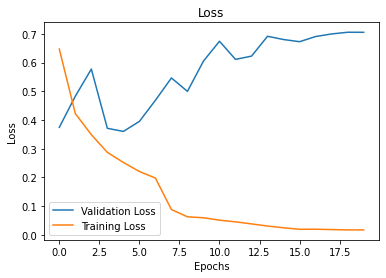

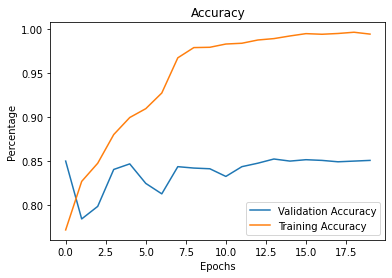

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation

if __name__ == "__main__":
    
    # note: i did not use randomresized crop as some data typically have a black circle encompassing
    # the slides from the microscope. To normalize this, I cropped around the center. - Kris
    data_transforms = {
        'train': transforms.Compose([
            # transforms.RandomResizedCrop(224),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    # DATA DIRECTORY
    data_dir = 'C:\\Users\\Kris\\..vs code files\\senior design\\images\\data-final'
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    inputs, classes = next(iter(dataloaders['train']))
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    
#    imshow(out, title=[class_names[x] for x in classes])
#    
    
    model_ft = models.vgg16(pretrained=True)
    # model_ft = models.resnet152(pretrained=True)
    # num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    #model_ft.fc = nn.Linear(num_ftrs, 2)
    
    model_ft = model_ft.to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    num_epochs = 20
    model_ft, vl, va, tl, ta = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs= 20)
    
    va = [x.item() for x in va]
    ta = [x.item() for x in ta]
    x = np.arange(num_epochs)
    plt.figure()
    plt.plot(x, vl, tl)
    plt.legend(['Validation Loss', 'Training Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.savefig('C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\results\\graphs\\4-18_vgg_lossC.png')
    
    plt.figure()
    plt.plot(x, va, ta)
    plt.legend(['Validation Accuracy', 'Training Accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Percentage')
    plt.title('Accuracy')
    plt.savefig('C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\results\\graphs\\4-18_vgg_accuracyC.png')
    
    
 #%%   
   
    out_data = pd.DataFrame([vl, va, tl, ta])
    out_data = out_data.T
    out_data.columns = ['val_loss', 'val_acc', 'train_loss', 'train_acc']
    out_data.to_csv("C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\results\\graphs\\4-18_vgg_training_dataC.txt", sep = '\t', index = False)
    
    #%%
    
    torch.save(model_ft,"C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\model\\4-18_vgg_modelC.pt")
    
    torch.save(model_ft.state_dict(),"C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\model\\4-18_vgg_model_state_dictC.pt")